In [131]:
import re
import string
import pandas as pd

def clean_tweet(tweet):
   
   
    tweet = re.sub(r'http\S+|www\S+', '', tweet)   # Hapus URL
    tweet = re.sub(r'@\w+', '', tweet)              # Hapus mention
    tweet = re.sub(r'#', '', tweet)                 # Hapus simbol hashtag
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    tweet = re.sub(r'\d+', '', tweet)               # Hapus angka
    tweet = tweet.lower()                           # Ubah ke huruf kecil
    tweet = tweet.strip()                           # Hapus spasi awal/akhir
    tweet = re.sub(r'\s+', ' ', tweet)              # Hilangkan spasi ekstra
    return tweet
def remove_non_ascii(text):
    return text.encode('ascii', 'ignore').decode('ascii')
# Baca data mentah dari file teks (pastikan file 'raw_tweets.txt' berada di direktori yang sama)
with open('raw_tweets.txt', 'r', encoding='utf-8') as file:
    raw_data = file.read()

raw_tweet_list = [t.strip() for t in raw_data.split("Tweet:") if t.strip()]

cleaned_tweet_list = [clean_tweet(tweet) for tweet in raw_tweet_list]
cleaned_tweet_list = [remove_non_ascii(tweet) for tweet in cleaned_tweet_list]
# Buat DataFrame menggunakan Pandas
df = pd.DataFrame({'cleaned_tweet': cleaned_tweet_list})

# Simpan DataFrame ke file CSV
df.to_csv('cleaned_tweets.csv', index=False, encoding='utf-8')

print("Data tweet telah dibersihkan dan disimpan ke file 'cleaned_tweets.csv'.")
df.to_csv('cleaned_tweets_no_emoji.csv', index=False, encoding='utf-8-sig')

Data tweet telah dibersihkan dan disimpan ke file 'cleaned_tweets.csv'.


In [8]:
!pip install yfinance



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [132]:
import pandas as pd
import yfinance as yf
import datetime
import random
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# === Bagian A: Proses Data Tweet ===

# Pastikan lexicon VADER sudah di-download
nltk.download('vader_lexicon', quiet=True)

# Baca file CSV tweet yang sudah dianalisis sentimennya
df = pd.read_csv('cleaned_tweets_with_sentiment.csv', encoding='utf-8-sig')

# Jika tidak ada kolom 'created_at', asumsikan semua tweet terjadi hari ini
if 'created_at' not in df.columns:
    today = datetime.date.today()
    df['created_at'] = today

# Buat kolom 'date' (bagian tanggal saja)
df['date'] = pd.to_datetime(df['created_at']).dt.date

# Pastikan kolom teks tweet ada (misalnya 'cleaned_tweet')
if 'cleaned_tweet' not in df.columns:
    raise KeyError("Kolom 'cleaned_tweet' tidak ditemukan dalam data tweet.")

# Inisialisasi VADER dan hitung skor sentimen
sia = SentimentIntensityAnalyzer()
def get_sentiment(text):
    if pd.isna(text):
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    return sia.polarity_scores(str(text))
df['sentiment'] = df['cleaned_tweet'].apply(get_sentiment)
df['compound'] = df['sentiment'].apply(lambda x: x.get('compound', 0))
df['pos']      = df['sentiment'].apply(lambda x: x.get('pos', 0))
df['neu']      = df['sentiment'].apply(lambda x: x.get('neu', 0))
df['neg']      = df['sentiment'].apply(lambda x: x.get('neg', 0))

# Untuk keperluan testing, simulasikan tanggal tweet agar tersebar selama periode 2023-01-02 hingga 2023-01-08
start_sim = datetime.date(2023, 1, 2)
end_sim = datetime.date(2023, 1, 8)
# Buat daftar tanggal simulasi
date_range = [start_sim + datetime.timedelta(days=i) for i in range((end_sim - start_sim).days + 1)]
# Assign secara acak satu tanggal dari date_range untuk setiap tweet
df['date'] = df.apply(lambda row: random.choice(date_range), axis=1)
print("Tanggal tweet setelah simulasi:", df['date'].unique())

# Simpan ulang data tweet dengan tanggal simulasi (opsional)
df.to_csv('cleaned_tweets_with_sentiment.csv', index=False, encoding='utf-8-sig')

# === Bagian B: Ambil Data Harga BTC dari yfinance ===

# Tentukan rentang tanggal yang sama dengan simulasi tweet
start_date = datetime.date(2023, 1, 1)
end_date = datetime.date(2023, 1, 8)
btc_data = yf.download("BTC-USD", start=str(start_date), end=str(end_date))
btc_data.reset_index(inplace=True)
btc_data['Date'] = pd.to_datetime(btc_data['Date']).dt.date
print("Rentang tanggal harga BTC:", btc_data['Date'].min(), btc_data['Date'].max())

# Flatten dan ubah nama kolom btc_data ke huruf kecil
if isinstance(btc_data.columns, pd.MultiIndex):
    btc_data.columns = ['_'.join(map(str, col)).lower().strip('_') for col in btc_data.columns.values]
else:
    btc_data.columns = btc_data.columns.str.lower()

# Rename kolom dari data BTC untuk menghindari konflik (sesuai dengan output; perhatikan nama kolom yang dihasilkan)
btc_data = btc_data.rename(columns={
    'open': 'open_btc',
    'high': 'high_btc',
    'low': 'low_btc',
    'close': 'close_btc',
    'adj close': 'adj_close_btc',
    'volume': 'volume_btc'
})
print("Kolom pada btc_data setelah rename:", btc_data.columns.tolist())

# === Bagian C: Merge Data Tweet dan Data Harga BTC ===

merged_data = pd.merge(df, btc_data, left_on="date", right_on="date", how="inner")
print("Bentuk data gabungan:", merged_data.shape)
print("Kolom pada merged_data:", merged_data.columns.tolist())
print("Contoh tanggal gabungan:", merged_data['date'].drop_duplicates())

if merged_data.empty:
    raise ValueError("Data gabungan kosong. Pastikan rentang tanggal pada tweet dan harga BTC memiliki overlap.")

# === Bagian D: Agregasi Data Harian ===

# Debug: Lihat daftar kolom yang ada di merged_data
cols = merged_data.columns.tolist()
print("Debug: Kolom hasil merge:", cols)

# Karena hasil rename menghasilkan nama kolom seperti "close_btc-usd" dan "volume_btc-usd",
# gunakan nama tersebut pada saat agregasi.
daily_data = merged_data.groupby('date').agg({
    'close_btc-usd': 'mean',
    'volume_btc-usd': 'mean',
    'compound': 'mean'
}).reset_index()

# Ubah kolom 'compound' menjadi 'avg_compound'
daily_data.rename(columns={'compound': 'avg_compound'}, inplace=True)
print("Data harian setelah agregasi:")
print(daily_data.head())

# Simpan hasil agregasi ke file CSV
daily_data.to_csv('aggregated_daily_data.csv', index=False, encoding='utf-8-sig')
print("File 'aggregated_daily_data.csv' telah dibuat.")


[*********************100%***********************]  1 of 1 completed

Tanggal tweet setelah simulasi: [datetime.date(2023, 1, 2) datetime.date(2023, 1, 3)
 datetime.date(2023, 1, 5) datetime.date(2023, 1, 6)
 datetime.date(2023, 1, 8) datetime.date(2023, 1, 7)
 datetime.date(2023, 1, 4)]
Rentang tanggal harga BTC: 2023-01-01 2023-01-07
Kolom pada btc_data setelah rename: ['date', 'close_btc-usd', 'high_btc-usd', 'low_btc-usd', 'open_btc-usd', 'volume_btc-usd']
Bentuk data gabungan: (90, 13)
Kolom pada merged_data: ['cleaned_tweet', 'sentiment', 'compound', 'pos', 'neu', 'neg', 'created_at', 'date', 'close_btc-usd', 'high_btc-usd', 'low_btc-usd', 'open_btc-usd', 'volume_btc-usd']
Contoh tanggal gabungan: 0     2023-01-02
1     2023-01-03
3     2023-01-05
4     2023-01-06
7     2023-01-07
11    2023-01-04
Name: date, dtype: object
Debug: Kolom hasil merge: ['cleaned_tweet', 'sentiment', 'compound', 'pos', 'neu', 'neg', 'created_at', 'date', 'close_btc-usd', 'high_btc-usd', 'low_btc-usd', 'open_btc-usd', 'volume_btc-usd']
Data harian setelah agregasi:
     

In [134]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Baca data harian hasil agregasi yang telah dibuat (pastikan file ini ada)
# Misalnya file ini dihasilkan dari proses merge & agregasi sebelumnya
daily_data = pd.read_csv('aggregated_daily_data.csv', encoding='utf-8-sig')
# Jika Anda belum menyimpan hasil agregasi, Anda bisa menggunakan DataFrame 'daily_data' yang telah dicetak sebelumnya.

# Periksa kolom yang ada
print("Kolom pada data harian:", daily_data.columns.tolist())

# Kita asumsikan kolom yang tersedia adalah:
# 'date', 'close_btc-usd', 'volume_btc-usd', 'avg_compound'
# Jika 'avg_compound' belum ada, pastikan Anda telah menggantinya dari 'compound' pada proses agregasi.
# Jika Anda belum memiliki fitur lag, kita buat sekarang.

# Sort data berdasarkan tanggal (pastikan format date sudah benar)
daily_data['date'] = pd.to_datetime(daily_data['date'])
daily_data = daily_data.sort_values(by='date')

# Buat fitur lag:
daily_data['close_lag1'] = daily_data['close_btc-usd'].shift(1)
daily_data['sentiment_lag1'] = daily_data['avg_compound'].shift(1)

# Hapus baris yang mengandung NaN (biasanya baris pertama)
daily_data_model = daily_data.dropna().copy()

print("Data untuk modeling (setelah membuat fitur lag):")
print(daily_data_model.head())

# Siapkan fitur dan target.
features = ['close_lag1', 'sentiment_lag1', 'volume_btc-usd']
target = 'close_btc-usd'

X = daily_data_model[features]
y = daily_data_model[target]

# Bagi data secara kronologis (misalnya 80% training, 20% testing)
n = len(daily_data_model)
train_size = int(n * 0.8)
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

# Melatih model RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Lakukan prediksi pada data test
y_pred = model.predict(X_test)

# Evaluasi model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Evaluasi Model:")
print("MAE:", mae)
print("RMSE:", rmse)

# Tambahkan hasil prediksi ke data
daily_data_model.loc[X_test.index, 'predicted_close'] = y_pred

# Simpan hasil prediksi ke file CSV
daily_data_model.to_csv('ml_prediction_results.csv', index=False, encoding='utf-8-sig')
print("File 'ml_prediction_results.csv' telah dibuat.")


Kolom pada data harian: ['date', 'close_btc-usd', 'volume_btc-usd', 'avg_compound']
Data untuk modeling (setelah membuat fitur lag):
        date  close_btc-usd  volume_btc-usd  avg_compound    close_lag1  \
1 2023-01-03   16679.857422    1.390308e+10      0.068189  16688.470703   
2 2023-01-04   16863.238281    1.842174e+10      0.006156  16679.857422   
3 2023-01-05   16836.736328    1.369276e+10      0.226480  16863.238281   
4 2023-01-06   16951.968750    1.441366e+10      0.024314  16836.736328   
5 2023-01-07   16955.078125    7.714767e+09      0.176888  16951.968750   

   sentiment_lag1  
1        0.227686  
2        0.068189  
3        0.006156  
4        0.226480  
5        0.024314  
Evaluasi Model:
MAE: 122.10652343749825
RMSE: 122.10652343749825
File 'ml_prediction_results.csv' telah dibuat.


Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best MAE (negated): 138.13181152343654
Evaluasi Best Model:
MAE: 128.65416259765698
RMSE: 128.65416259765698


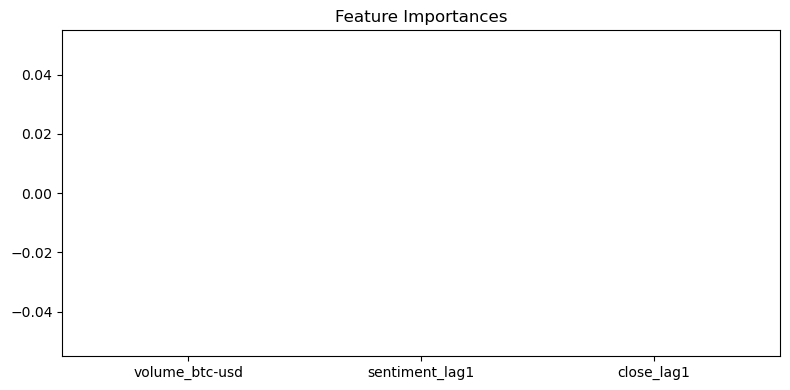

In [137]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

#  GridSearch untuk RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Karena data time-series, gunakan TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), 
                           param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best MAE (negated):", -grid_search.best_score_)

# Gunakan model terbaik untuk prediksi
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print("Evaluasi Best Model:")
print("MAE:", mae_best)
print("RMSE:", rmse_best)

plt.figure(figsize=(8, 4))
plt.title("Feature Importances")
plt.bar(range(len(features_list)), importances[indices], align='center')
plt.xticks(range(len(features_list)), [features_list[i] for i in indices])
plt.tight_layout()
plt.show()


Data harian sebelum fitur lag:
        date  close_btc-usd  volume_btc-usd  avg_compound
0 2023-01-02   16688.470703    1.209778e+10      0.227686
1 2023-01-03   16679.857422    1.390308e+10      0.068189
2 2023-01-04   16863.238281    1.842174e+10      0.006156
3 2023-01-05   16836.736328    1.369276e+10      0.226480
4 2023-01-06   16951.968750    1.441366e+10      0.024314

Data untuk modeling (setelah membuat fitur lag):
        date  close_btc-usd  volume_btc-usd  avg_compound    close_lag1  \
0 2023-01-03   16679.857422    1.390308e+10      0.068189  16688.470703   
1 2023-01-04   16863.238281    1.842174e+10      0.006156  16679.857422   
2 2023-01-05   16836.736328    1.369276e+10      0.226480  16863.238281   
3 2023-01-06   16951.968750    1.441366e+10      0.024314  16836.736328   
4 2023-01-07   16955.078125    7.714767e+09      0.176888  16951.968750   

   sentiment_lag1  
0        0.227686  
1        0.068189  
2        0.006156  
3        0.226480  
4        0.024314  


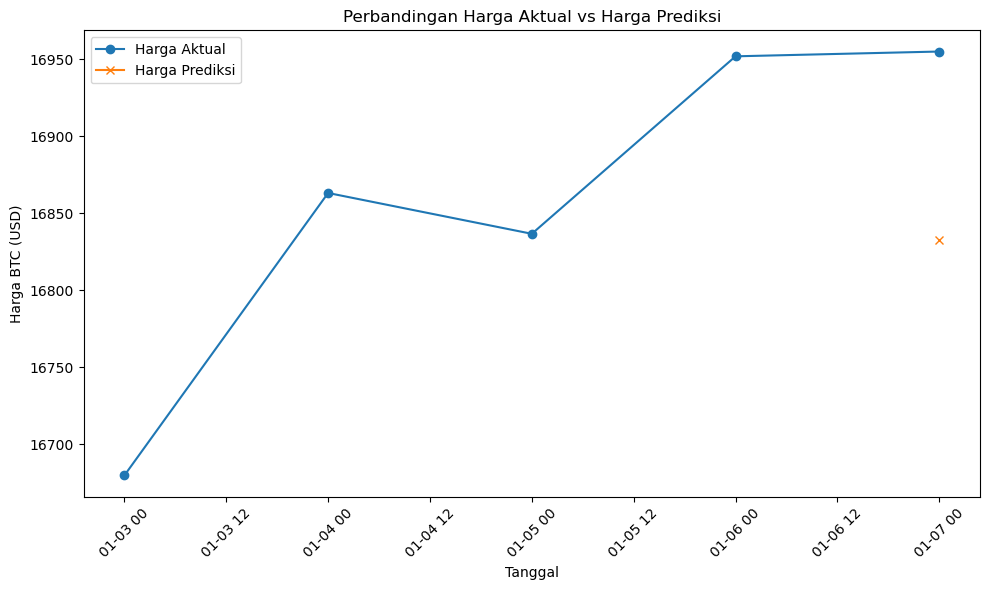

Beberapa nilai prediksi:
        date  close_btc-usd  predicted_close
0 2023-01-03   16679.857422              NaN
1 2023-01-04   16863.238281              NaN
2 2023-01-05   16836.736328              NaN
3 2023-01-06   16951.968750              NaN
4 2023-01-07   16955.078125     16832.971602


In [155]:
import pandas as pd
import numpy as np
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# === Tahap 1: Muat Data Agregasi Harian ===
daily_data = pd.read_csv('aggregated_daily_data.csv', encoding='utf-8-sig')

# Pastikan kolom 'date' diubah ke tipe datetime untuk sorting dan plotting
daily_data['date'] = pd.to_datetime(daily_data['date'])

# Tampilkan data awal
print("Data harian sebelum fitur lag:")
print(daily_data.head())

# === Tahap 2: Buat Fitur Lag ===
# Fitur lag: Harga penutupan hari sebelumnya dan rata-rata sentimen hari sebelumnya
daily_data = daily_data.sort_values(by='date').reset_index(drop=True)
daily_data['close_lag1'] = daily_data['close_btc-usd'].shift(1)
daily_data['sentiment_lag1'] = daily_data['avg_compound'].shift(1)

# Hapus baris yang memiliki nilai NaN (biasanya baris pertama)
model_data = daily_data.dropna().reset_index(drop=True)
print("\nData untuk modeling (setelah membuat fitur lag):")
print(model_data.head())

# === Tahap 3: Siapkan Data untuk Modeling ===
# Misalnya, target adalah harga penutupan hari ini ('close_btc-usd')
# dan fitur yang digunakan adalah harga penutupan hari sebelumnya, sentimen lag, serta volume.
features = ['close_lag1', 'sentiment_lag1', 'volume_btc-usd']
target = 'close_btc-usd'
X = model_data[features]
y = model_data[target]

# Bagi data secara kronologis (misalnya 80% untuk training, 20% untuk testing)
n = len(model_data)
train_size = int(n * 0.8)
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

print("\nUkuran data training:", X_train.shape)
print("Ukuran data testing:", X_test.shape)

# === Tahap 4: Latih Model RandomForestRegressor ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediksi harga pada data testing
y_pred = model.predict(X_test)
model_data.loc[X_test.index, 'predicted_close'] = y_pred
# Evaluasi model dengan MAE dan RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nEvaluasi Model:")
print("MAE:", mae)
print("RMSE:", rmse)

# === Tahap 5: Tambahkan Hasil Prediksi ke Data ===
# Buat kolom 'predicted_close' di DataFrame model_data
model_data.loc[X_test.index, 'predicted_close'] = y_pred

# Simpan data modeling yang sudah lengkap ke file CSV baru
model_data.to_csv('ml_prediction_results.csv', index=False, encoding='utf-8-sig')
print("\nFile 'ml_prediction_results.csv' telah dibuat.")

# === Tahap 6: Buat Grafik Perbandingan Harga Aktual vs Prediksi ===
#Tanggal 2023‑01‑03, 2023‑01‑04, 2023‑01‑05, dan 2023‑01‑06 tidak memiliki nilai prediksi karena merupakan bagian dari data training.
#Tanggal 2023‑01‑07 adalah bagian dari data testing, sehingga model memberikan prediksi harga BTC sebesar sekitar 16832.97.

plt.figure(figsize=(10, 6))
plt.plot(model_data['date'], model_data['close_btc-usd'], label='Harga Aktual', marker='o')
plt.plot(model_data['date'], model_data['predicted_close'], label='Harga Prediksi', marker='x')
plt.xlabel('Tanggal')
plt.ylabel('Harga BTC (USD)')
plt.title('Perbandingan Harga Aktual vs Harga Prediksi')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print("Beberapa nilai prediksi:")
print(model_data[['date', 'close_btc-usd', 'predicted_close']].head())
